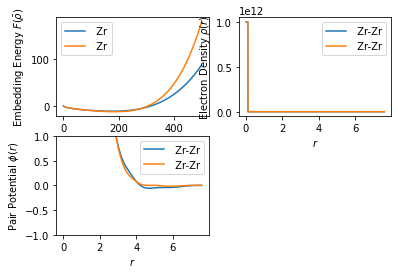

In [10]:
#sinusoid
from ase.build import bulk
from ase import Atoms
from ase.atom import Atom
from ase.calculators.emt import EMT
from ase.phonons import Phonons
from ase.dft.kpoints import *
import matplotlib.pyplot as plt
import numpy as np
from ase.calculators.eam import EAM
from ase.md import verlet
from ase.md.verlet import VelocityVerlet
from ase import units
from ase.calculators.lj import LennardJones


zr1 = EAM(potential='Zr_3.eam.fs')
zr1.write_potential('Zr_3.eam.fs')
zr1.plot()

zr2 = EAM(potential='Zr_2.eam.fs')
zr2.write_potential('Zr_2.eam.fs')
zr2.plot()


In [11]:
def G_bcc(T,V):
    k = 8.617333262e-5
    
    temp = str(T)
    vol = str(V)
    tempname = (vol+"_"+temp + "_phonon" +  "_bcc")
    
    a_ = (2*V)**(1/3)

    atoms = bulk('Zr', 'bcc',  a=a_)
    atoms.calc = zr2
    N = 7
    ph = Phonons(atoms, zr2, supercell=(N, N, N), delta=0.05,name = tempname)
    ph.run()
    ph.read(acoustic=True)
    ph.clean()

    #Trial1:
    kv=(7, 7, 7)
    kvc = monkhorst_pack(kv)
    omega_kl = ph.band_structure(kvc,verbose = False)

    return omega_kl



def G_hcp(T,V):
    k = 8.617333262e-5
    
    a_ = (V/np.sqrt(2))**(1/3)
    
    temp = str(T)
    vol = str(V)
    tempname = (vol+"_"+temp + "_phonon" +  "_hcp")
    
    atoms = bulk('Zr', 'hcp',  a=a_, c = 1.633*a_)
    atoms.calc = zr2
    N = 7
    ph = Phonons(atoms, zr2, supercell=(N, N, N), delta=0.05,name = tempname)
    ph.run()
    ph.read(acoustic=True)
    ph.clean()

    #Trial1:
    kv=(7, 7, 7)
    kvc = monkhorst_pack(kv)
    omega_kl = ph.band_structure(kvc,verbose = False)
    
    return omega_kl
    

    

In [12]:
def differential_hcp(V,T):
    
    V1 = V+0.005
    V2 = V-0.005
    omega1 = np.array(G_hcp(T,V1))
    omega2 = np.array(G_hcp(T,V2))
    P = (omega1 - omega2)/0.01
    
    return P

def differential_bcc(V,T):
    
    V1 = V+0.005
    V2 = V-0.005
    omega1 = np.array(G_bcc(T,V1))
    omega2 = np.array(G_bcc(T,V2))
    P = (omega1 - omega2)/0.01
    
    return P


        
        

In [13]:
def cvt(omega_kl,T):
    k = 8.617333262e-5
    w = np.copy(omega_kl)
    d = k*(w/(k*T))**2*(np.exp(w/k*T)/(np.exp(w/k*T)**2 - 1)**2)    

    return d
    
    

In [14]:
def Gruneisen_hcp(V,T):
    omega_kl = G_hcp(V,T)
    omega = np.abs(np.array(omega_kl))
    diff = differential_hcp(V,T)
    g = diff*(V/omega)
    c = cvt(omega,T)
    gamma = np.sum(np.multiply(g,c))/np.sum(c)
    
    return gamma,g

def Gruneisen_bcc(V,T):
    
    omega_kl = G_bcc(V,T)
    omega = np.abs(np.array(omega_kl))
    diff = differential_bcc(V,T)
    g = diff*(V/omega)
    c = cvt(omega,T)
    gamma = np.sum(np.multiply(g,c))/np.sum(c)
    
    return gamma,g

In [15]:
atoms = bulk('Zr', 'hcp',  a=3.23, b = 5.18)
#atoms = bulk('Zr', 'bcc',  a=3.6)
atoms.get_volume()

46.80211033403901

In [16]:

V_bcc = [22,22.5,23,23.5,24,24.5]
V_hcp = [45.5,46,46.5,47,47.5,48]

T = [100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400]

In [ ]:
Grun_b = np.zeros(shape=(6,14))
Grun_h = np.zeros(shape=(6,14))

for i in range(len(V_bcc)):
    for j in range(len(T)):
        gammab,gb = Gruneisen_bcc(V_bcc[i],T[j])
        gammah,gh = Gruneisen_hcp(V_hcp[i],T[j])
        Grun_b[i][j] = gammab
        Grun_h[i][j] = gammah
        print("i: " + str(i) + " out of 6, j: " + str(j) + "out of 14")

<ipython-input-13-bae0221607a4>:4: RuntimeWarning: overflow encountered in exp
  d = k*(w/(k*T))**2*(np.exp(w/k*T)/(np.exp(w/k*T)**2 - 1)**2)
<ipython-input-13-bae0221607a4>:4: RuntimeWarning: invalid value encountered in divide
  d = k*(w/(k*T))**2*(np.exp(w/k*T)/(np.exp(w/k*T)**2 - 1)**2)
<ipython-input-13-bae0221607a4>:4: RuntimeWarning: overflow encountered in square
  d = k*(w/(k*T))**2*(np.exp(w/k*T)/(np.exp(w/k*T)**2 - 1)**2)


i: 0 out of 6, j: 0out of 14
i: 0 out of 6, j: 1out of 14
i: 0 out of 6, j: 2out of 14


<ipython-input-14-ec4accae8b4d>:16: RuntimeWarning: divide by zero encountered in divide
  g = diff*(V/omega)
<ipython-input-13-bae0221607a4>:4: RuntimeWarning: divide by zero encountered in divide
  d = k*(w/(k*T))**2*(np.exp(w/k*T)/(np.exp(w/k*T)**2 - 1)**2)
<ipython-input-13-bae0221607a4>:4: RuntimeWarning: invalid value encountered in multiply
  d = k*(w/(k*T))**2*(np.exp(w/k*T)/(np.exp(w/k*T)**2 - 1)**2)


i: 0 out of 6, j: 3out of 14
i: 0 out of 6, j: 4out of 14
i: 0 out of 6, j: 5out of 14


<ipython-input-14-ec4accae8b4d>:5: RuntimeWarning: divide by zero encountered in divide
  g = diff*(V/omega)


i: 0 out of 6, j: 6out of 14
i: 0 out of 6, j: 7out of 14
i: 0 out of 6, j: 8out of 14
i: 0 out of 6, j: 9out of 14
i: 0 out of 6, j: 10out of 14
i: 0 out of 6, j: 11out of 14
i: 0 out of 6, j: 12out of 14
i: 0 out of 6, j: 13out of 14
i: 1 out of 6, j: 0out of 14
i: 1 out of 6, j: 1out of 14
i: 1 out of 6, j: 2out of 14
i: 1 out of 6, j: 3out of 14
i: 1 out of 6, j: 4out of 14
i: 1 out of 6, j: 5out of 14
i: 1 out of 6, j: 6out of 14
i: 1 out of 6, j: 7out of 14
i: 1 out of 6, j: 8out of 14
i: 1 out of 6, j: 9out of 14
i: 1 out of 6, j: 10out of 14
i: 1 out of 6, j: 11out of 14
i: 1 out of 6, j: 12out of 14
i: 1 out of 6, j: 13out of 14
i: 2 out of 6, j: 0out of 14
i: 2 out of 6, j: 1out of 14
i: 2 out of 6, j: 2out of 14
i: 2 out of 6, j: 3out of 14
i: 2 out of 6, j: 4out of 14
i: 2 out of 6, j: 5out of 14
i: 2 out of 6, j: 6out of 14
i: 2 out of 6, j: 7out of 14
i: 2 out of 6, j: 8out of 14
i: 2 out of 6, j: 9out of 14
